### Load Files

In [115]:
# Custom functions
from custom_functions import *

# Aesthetics and utils
import os
from IPython.core.display import display

# Data maniputalion
from datetime import datetime
import re
import numpy as np
import pandas as pd

import scipy.stats as stats
from scipy.spatial.distance import squareform

# Pandas config
pd.set_option('display.float_format', lambda x: '%.2f' % x) # supress scientific notation
pd.set_option('display.max_columns', 100)                   # increase max columns displayed
pd.set_option('display.max_rows', 15)                       # increase max columns displayed

# Saving binary files
import pickle

# Data visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning
import sklearn

# Disable warnings - useless most of the time
import warnings
warnings.filterwarnings('ignore')

# Terminal colors
WHITE = '\033[39m'
CYAN = '\033[36m'
GREEN = '\033[32m'
RED = '\033[31m'

# Color pallete for plotting
colors = {
    'cyan': '#1696d2',
    'gray': '#5c5859',
    'black': '#000000',
    'yellow': '#fdbf11',
    'orange': '#ca5800',
    'magenta': '#af1f6b',
    'green': '#408941',
    'red': '#a4201d'
}

# Check Libraries version
print(f'Numpy: {np.__version__}')
print(f'Pandas: {pd.__version__}')
print(f'Sklearn: {sklearn.__version__}')
print(f'Matplotlib: {matplotlib.__version__}')
print(f'Seaborn: {sns.__version__}')
print(datetime.now().strftime('Last run on %d/%m/%Y at %H:%M:%S'))


# Markdown styling
# header 1 - yellow 
# <a style='font-family:Lato,sans-serif;color:#fdbf11;font-size: 1em;'>
# header 2 - blue #46abdb
## <a style='font-family:Lato,sans-serif;color:#1696d2;font-size: 1em;'>

Numpy: 1.20.3
Pandas: 1.3.4
Sklearn: 1.0.2
Matplotlib: 3.1.1
Seaborn: 0.11.2
Last run on 12/04/2022 at 16:39:35


In [3]:
description_df = pd.read_csv('data/HomeCredit_columns_description.csv')
description_df.drop('Unnamed: 0', axis=1, inplace=True)
df_train = pd.read_csv('data/application_train.csv')
pd.set_option('display.max_colwidth', None)

## <span id='baseline' style='color:Gold'>3. First Cycle - Baseline Model

For the baseline model, we will create a pipeline with the following steps:  
- Split data into train/test;  
- Deal NA values with `sklearn SimpleImputer`, with `strategy=mean` for numeric features and  `strategy=constant` with `'unknow'` value for categorical features;  
- Scale data using `StandartScaler`;  
- Use `LogisticRegression` as the baseline estimator.  

#### Split data into train/test and stratify with Target

In [ ]:
from sklearn.model_selection import train_test_split

X = df_train.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = df_train['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)

#### Set pipeline for *numeric features*

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [ ]:
numeric_features_pipeline = Pipeline([
    ('impute_num', SimpleImputer(strategy='mean')),
    ('std', MinMaxScaler())
])

numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()

#### Set pipeline for *categorical features*

In [ ]:
categorical_features_pipeline = Pipeline([
    ('impute_cat', SimpleImputer(strategy='constant', fill_value='unknow')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()

#### Create a pre-processing pipeline for `ColumnTransformer`

In [ ]:
from sklearn.compose import ColumnTransformer

pre_processing_pipeline = ColumnTransformer([
    ('numeric_transformer', numeric_features_pipeline, numeric_features),
    ('categorical_transformer', categorical_features_pipeline ,categorical_features)
])

#### Create `Pipeline` and fit model

In [ ]:
from sklearn.linear_model import LogisticRegression

# create final pipeline
baseline_pipeline = Pipeline([
    ('pre_processing', pre_processing_pipeline),
    ('lr', LogisticRegression(random_state=42))
])
# fit to model
baseline_pipeline.fit(X_train, y_train)

Pipeline(steps=[('pre_processing',
                 ColumnTransformer(transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('impute_num',
                                                                   SimpleImputer()),
                                                                  ('std',
                                                                   MinMaxScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTR

#### Predict values from train and test dataset

In [ ]:
y_pred_train = baseline_pipeline.predict(X_train)
y_pred_test = baseline_pipeline.predict(X_test)
y_proba_train = baseline_pipeline.predict_proba(X_train)
y_proba_test = baseline_pipeline.predict_proba(X_test)

#### Evaluate baseline model metrics with `roc_auc_score`

ROC AUC Score for Train dataset: 0.7464670080661555
ROC AUC Score for Test dataset: 0.7445526644683004

Train data Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96    180830
           1       0.49      0.01      0.02     15976

    accuracy                           0.92    196806
   macro avg       0.70      0.51      0.49    196806
weighted avg       0.88      0.92      0.88    196806

Test data Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     45208
           1       0.43      0.01      0.02      3994

    accuracy                           0.92     49202
   macro avg       0.68      0.50      0.49     49202
weighted avg       0.88      0.92      0.88     49202



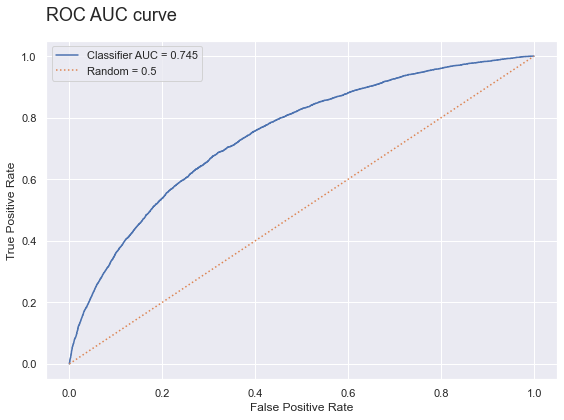

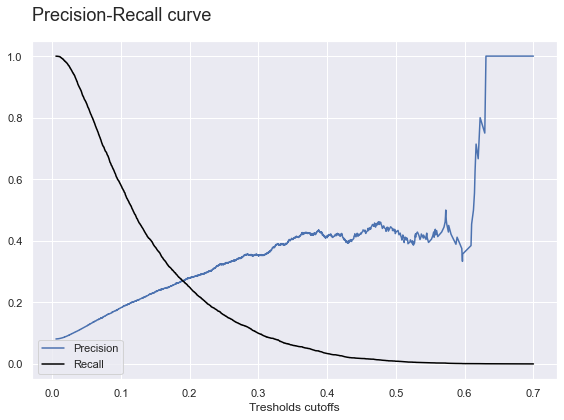

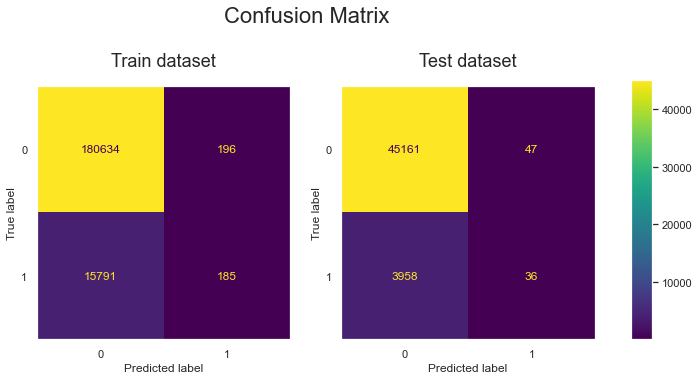

In [ ]:
display_classification_metrics(baseline_pipeline, X_train, X_test, y_train, y_test)

The baseline model hit a score of **0.745**.  
  
For the next cycle, we will apply hyperparameter tunning and use different estimators, like `RandomForest` and `GradientBoosting`

#### Saving model

In [ ]:
# saving baseline_pipeline
with open('pickle_data/baseline_model.pickle', 'wb') as file:
    pickle.dump(baseline_pipeline, file, protocol=pickle.HIGHEST_PROTOCOL)